# One-way Analysis of Variance (ANOVA)

ANOVA is a null-hypothesis significance test used to compare differences between groups on a categorical independent variable (IV) in terms of their group mean score on a scale dependent variable (DV). ANOVA is an ominbus test that allows us to compare the means of multiple groups with a single test while controlling for the family-wise error rate (type 1 error). Where the t-test is frequently used to compare the mean scores on two groups, ANOVA is used to see if three or more groups differ significantly in terms of their mean score on the DV. 

A significant ANOVA with three or more groups tells us that at least two of the groups (those with the lowest and highest mean) differ significantly but we must also conduct follow-up post-hoc tests to compare all pairs of groups to see if any others differ signficantly in terms of their mean score on the DV. 

Here, I demonstrate One-way ANOVA. This is a design with one IV with three or more groups and one DV measured on a continuous scale. 

In [1]:
# Importing the key software libraries:

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

## Non-significant differences between groups

Starting with an example using simulated (made-up) data.

In [2]:
np.random.seed(12)

ethnic = ["asian", "black", "medit", "other", "white"]

# Create random data
voter_ethnic = np.random.choice(a = ethnic, p = [0.05, 0.15, 0.25, 0.05, 0.5], size = 1000)

# Here we are sampling from the same population so we should not expect a significant difference between the groups
# when sampled at random
voter_age = stats.poisson.rvs(loc = 18, mu = 30, size = 1000)

# Group age data by ethicity
voter_frame = pd.DataFrame({"ethnicity": voter_ethnic, "age": voter_age})
groups = voter_frame.groupby("ethnicity").groups

# Extract individual groups
asian = voter_age[groups["asian"]]
black = voter_age[groups["black"]]
medit = voter_age[groups["medit"]]
other = voter_age[groups["other"]]
white = voter_age[groups["white"]]

### Running a one-way ANOVA on the simulated data

Here we do not expect to see a signficant difference between groups. We would not routinely know this beforehand but we simulated the data and parameters such that we didn't set different means for the different groups.  

In [3]:
# Performing the one-way ANOVA comparing mean voter age between the different ethnic groups

stats.f_oneway(asian, black, medit, other, white)

F_onewayResult(statistic=1.7744689357329695, pvalue=0.13173183201930463)

The scipy.stats f_oneway method returns an F value and p-value. We can see here that the F value is 1.77 and the associated p-value is 0.13. This is an non-significant ANOVA result as expected from the way the data were generated (the same popn with the same mean). A result like this tells us that the mean voter age does not differ significantly between these different ethnic groups. 

### An alternative way to run ANOVA 

We can also run ANOVA using the statsmodels library. This allows us to use R style formulas for the model. 

In [4]:
# Importing the relevant statsmodels packages

import statsmodels.api as sm
from statsmodels.formula.api import ols

In [5]:
# Running a one-way ANOVA using formula syntax similar to that from the R programming language:
# This is the linear model formula
model = ols("age ~ ethnicity", data = voter_frame).fit()  

# Getting an ANOVA model from the above GLM model:
anova_res = sm.stats.anova_lm(model, typ=2) # Here with typ =2 we are specifiying type 2 sum of squares.
print(anova_res)

              sum_sq     df         F    PR(>F)
ethnicity    199.369    4.0  1.774469  0.131732
Residual   27948.102  995.0       NaN       NaN


Using this method we get the same result for the non-significant ANOVA as before. 

## Significant differences between groups

We are, again, going to simulate some data. This time we will create data where there is a difference between some of the groups in terms of mean voter age, so that we get a significant ANOVA result. 

In [6]:
# Simulating data with a group with a mean different to the population. 

np.random.seed(12)

ethnic = ["asian", "black", "medit", "other", "white"]

# Create random data
voter_ethnic = np.random.choice(a = ethnic, p = [0.05, 0.15, 0.25, 0.05, 0.5], size = 1000)

# Use a different distribution for the mean age of white voters. 
# This group has a mean of 32 whereas mu is set to 30 for the population. 
white_age = stats.poisson.rvs(loc = 18, mu = 32, size = 1000)
voter_age = stats.poisson.rvs(loc = 18, mu = 30, size = 1000)

voter_age = np.where(voter_ethnic == "white", white_age, voter_age)
# Group age data by ethicity
voter_frame = pd.DataFrame({"ethnicity": voter_ethnic, "age": voter_age})
groups = voter_frame.groupby("ethnicity").groups

# Extract individual groups
asian = voter_age[groups["asian"]]
black = voter_age[groups["black"]]
medit = voter_age[groups["medit"]]
other = voter_age[groups["other"]]
white = voter_age[groups["white"]]

In [7]:
# Runnng the scipy.stats ANOVA test:

stats.f_oneway(asian, black, medit, other, white)

F_onewayResult(statistic=10.164699828386366, pvalue=4.5613242113994585e-08)

This time we see that there is a significant difference between the ethinicity group in terms of mean voter age. Here we have an F value of 10.16 and a p-value of <0.001. 

### The same analysis using the statsmodels formula

In [8]:
model = ols("age ~ ethnicity", data = voter_frame).fit()  

anova_res = sm.stats.anova_lm(model, typ=2) 
print(anova_res)

                 sum_sq     df        F        PR(>F)
ethnicity   1284.123213    4.0  10.1647  4.561324e-08
Residual   31424.995787  995.0      NaN           NaN


Again, we see we have a significant result. Next we need to follow this up with post-hoc pairwise comparisons of all pairs of groups to see if they significantly differ from each other. 

## Post-hoc tests (pairwise comparisons)

### Bonferroni correction

One method of conducting post-hoc tests is to run multiple t-tests comparing each pair of groups and then adjust the threshold for a signficant test so that it is stricter, thereby controlling for the family-wise error rate. 

A common method for doing this is the Bonferroni method, whereby we simply divide the normal criterion for a significant p-value by the number of comparisons we are making (the number of test we are running) and then use the resulting value as our new threshold for a significant result. 

For example, if we were conducting 5 tests we would divide the normal alpha value for significance (0.05) by 5. 
0.05/5 = 0.01. This gives us a new alpha significance criterion for considering a hypothesis test to be significant of 0.01. If the p-value is less than 0.01, we would accept there is a significant different between the means of the two groups being compared. If the p-value is greater than 0.01 we would consider the difference to be non-significant. 

Below I demonstrate a way to manually run multiple t-tests on the above voter data that produced a significant ANOVA result. Each p-value can then be compared against an adjusted significance threshold. In this case we are making 10 comparisons so the Bonferroni correction and new level of alpha will be: 0.05/ 10 = 0.005. 

In [9]:
# Creating some syntax that runs through each ethnic group, matches it with another and then runs a t-test:

# Create an empty list to get all ethnic_pairs:

ethnic_pairs = []

for ethnic1 in range(4):
    for ethnic2 in range(ethnic1 + 1, 5):
        ethnic_pairs.append((ethnic[ethnic1], ethnic[ethnic2]))

# Conduct a t-test on each pair:
for ethnic1, ethnic2 in ethnic_pairs:
    print(ethnic1, ethnic2)
    print(stats.ttest_ind(voter_age[groups[ethnic1]], voter_age[groups[ethnic2]]))
    

asian black
Ttest_indResult(statistic=0.838644690974798, pvalue=0.4027281369339345)
asian medit
Ttest_indResult(statistic=-0.42594691924932293, pvalue=0.6704669004240726)
asian other
Ttest_indResult(statistic=0.9795284739636, pvalue=0.3298877500095151)
asian white
Ttest_indResult(statistic=-2.318108811252288, pvalue=0.020804701566400217)
black medit
Ttest_indResult(statistic=-1.9527839210712925, pvalue=0.05156197171952594)
black other
Ttest_indResult(statistic=0.28025754367057176, pvalue=0.7795770111117659)
black white
Ttest_indResult(statistic=-5.379303881281835, pvalue=1.039421216662395e-07)
medit other
Ttest_indResult(statistic=1.5853626170340225, pvalue=0.11396630528484335)
medit white
Ttest_indResult(statistic=-3.5160312714115376, pvalue=0.0004641298649066684)
other white
Ttest_indResult(statistic=-3.763809322077872, pvalue=0.00018490576317593065)


Looking at the above list of t-tests and associated p-values, we can see that, even with an adjusted level of significance, that there appear to be statistically significant differences between black - white (t = 5.38, p < 0.001); medit - white (t = 3.52, p = 0.0005); and other - white (t = 3.76, p = 0.0002). Based on what we know about the mean voter age for these groups (the data was constructed so that the mean age for white voters was older than the other groups) this indicates that the mean age for white voters was significantly higher than these three groups when we use the Bonferroni correction method. 

The Bonferroni correction is a conservative correction and we may risk making a type 2 error and rejecting significant differences that are actually significant by using this method of post-hoc adjustment and comparison. Another commonly used post-hoc test is the Tukey HSD test.

### Tukey HSD test

The Tukey HSD test is a less conservative (strict) test than Bonferroni and can be implemeted for pairwise comparisons using the statsmodels multicomparisons method. 

group1,group2,meandiff,p-adj,lower,upper,reject
asian,black,-0.8032,0.9208,-3.4423,1.836,False
asian,medit,0.4143,0.9915,-2.1011,2.9297,False
asian,other,-1.0645,0.8906,-4.2391,2.11,False
asian,white,1.9547,0.1751,-0.4575,4.3668,False
black,medit,1.2175,0.2318,-0.386,2.821,False
black,other,-0.2614,0.9986,-2.7757,2.253,False
black,white,2.7579,0.0,1.3217,4.194,True
medit,other,-1.4789,0.4374,-3.863,0.9053,False
medit,white,1.5404,0.004,0.3468,2.734,True
other,white,3.0192,0.0028,0.7443,5.2941,True


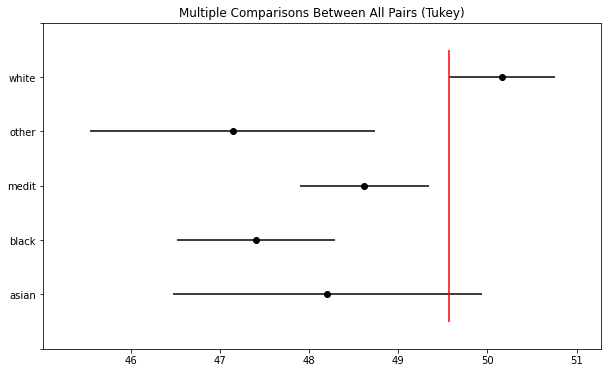

In [10]:
# To conduct the Tukey test we need to load it in from the statsmodels library. 

from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog = voter_age, groups = voter_ethnic, alpha = 0.05)
# Here endog = data, groups = the groups, alpha = sig level. 
tukey.plot_simultaneous() # Plot groups confidence intervals. 
plt.vlines(x = 49.57, ymin = -0.5, ymax = 4.5, color = "red")

tukey.summary() # to see the test output summary. 

Above we see some nice output for the Tukey HSD comparisons we conducted. In the table we can see the adjusted p-value for each t-test conducted. In this case we can interpret any test with an adjusted significance value below 0.05 as statistically different. We also get this nice column labelled reject. This tells us whether we should reject the null hypothesis using boolean logic. If reject equals True, then we reject the null hypothesis that the groups means are the same. If reject equals False then we cannot reject the null hypothesis and there is likely no significant difference between the two group means. 

Additionally, we have a forest plot showing the confidence intervals for the different groups and we can see with the red vline which groups do not have overlapping confidence intervals and are likely to have significantly different means. 

Note: The results of the Tukey HSD post-hoc test are indentical to the Bonferroni method and show signficant differences between the same three comparisons. This is not always likely to be the case as the two post-hoc tests differ in their strictness and Tukey HSD may identify a comparison as significant that did not reach the threshold using Bonferroni. 